# MNIST & SVMs

In this problem you will use a support vector machine (SVM) method to classify images from the
MNIST data set as discussed in the course lectures.
## (a) Obtain the MNIST data set
Obtain the dataset from
https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
in CSV format.


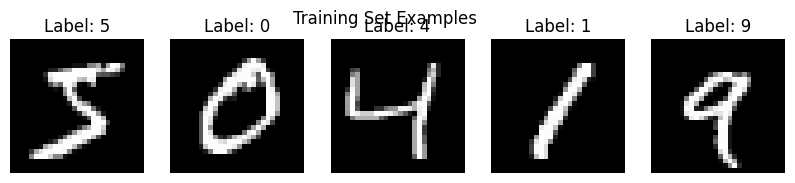

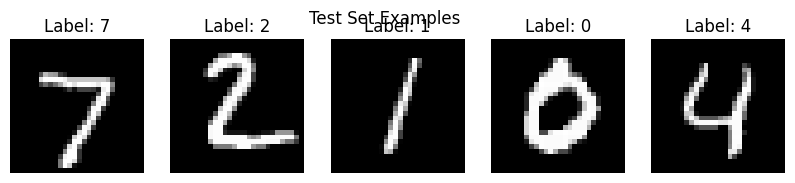

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB
None


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

# Function to plot a few examples
def plot_examples(data, title, num_examples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(data.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
        plt.title(f"Label: {data.iloc[i, 0]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize a few examples from the training set
plot_examples(train_data, "Training Set Examples")

# Visualize a few examples from the test set
plot_examples(test_data, "Test Set Examples")

# Inspect the training dataframe
print(train_data.info())
train_data.head()

## (b) Load the examples 
For a single value (say 5, but it doesn’t matter which you pick), load the examples from the
MNIST training and test sets that correspond to images of the value 5. Note that the first entry
in every row of the MNIST data set gives the value in the image, while the rest of the row is a
vector with 284 (i.e. 28 × 28) entries representing the image of the number as a column vector.


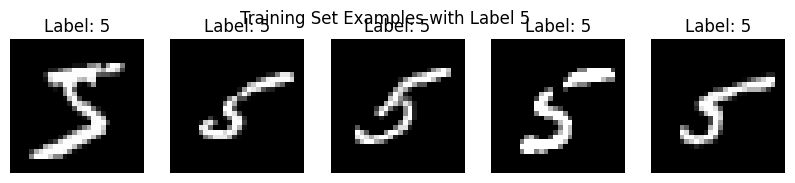

Number of training examples for label 5: 5421
Number of test examples for label 5: 892


In [8]:
# Filter the training and test sets for images of the value 5
train_data_5 = train_data[train_data['label'] == 5]
test_data_5 = test_data[test_data['label'] == 5]

# Visualize a few examples from the training set with label 5
plot_examples(train_data_5, "Training Set Examples with Label 5")

# Display the number of examples found
print(f"Number of training examples for label 5: {len(train_data_5)}")
print(f"Number of test examples for label 5: {len(test_data_5)}")

## (c) Train an SVM
Use the training data set to train a SVM model to classify each image in the training set as “5”
or “not 5”. You will need to do this parametrically for increasing values of λ. Choose the value λ
that gives the best classification rate for the test data set.


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Accuracy: 1.0


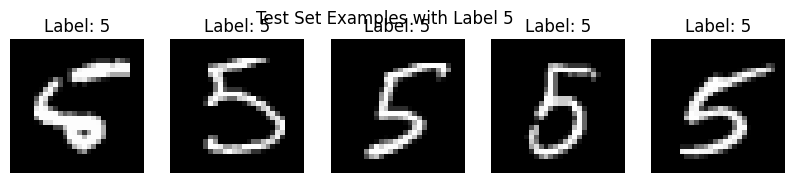

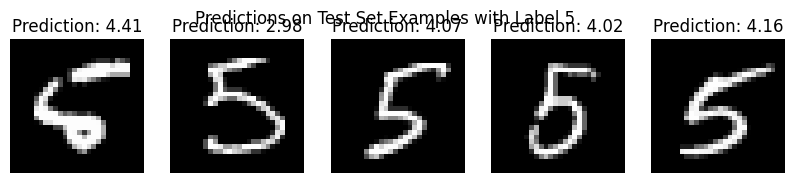

In [9]:
# Use pytorch to train an SVM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define the model
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.fc = nn.Linear(28 * 28, 1)

    def forward(self, x):
        return self.fc(x)

# Define the loss function
def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_pred.t() * y_true, min=0))

# Define the training function
def train_svm(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = hinge_loss(y_pred, y)
            loss.backward()
            optimizer.step()

# Prepare the data
X_train = torch.tensor(train_data_5.iloc[:, 1:].values / 255, dtype=torch.float32)

# Convert the labels to -1 and 1
y_train = torch.tensor(2 * (train_data_5['label'].values == 5) - 1, dtype=torch.float32)

# Create a DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model and optimizer
model = SVM()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
train_svm(model, train_loader, optimizer)

# Evaluate the model
X_test = torch.tensor(test_data_5.iloc[:, 1:].values / 255, dtype=torch.float32)
y_test = torch.tensor(2 * (test_data_5['label'].values == 5) - 1, dtype=torch.float32)

# Compute the predictions
y_pred = model(X_test).squeeze().detach().numpy()

# Compute the accuracy
accuracy = (y_pred * y_test.numpy() > 0).mean()
print(f"Accuracy: {accuracy}")

# Visualize a few examples from the test set with label 5
plot_examples(test_data_5, "Test Set Examples with Label 5")

# Visualize the predictions
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_data_5.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(f"Prediction: {y_pred[i]:.2f}")
    plt.axis('off')

plt.suptitle("Predictions on Test Set Examples with Label 5")
plt.show()



## (d) Do the same thing for all of the other numbers 0–9.


In [10]:
# Define the multiclass SVM using One-vs-Rest approach
class MultiClassSVM(nn.Module):
    def __init__(self, num_classes=10):
        super(MultiClassSVM, self).__init__()
        self.svms = nn.ModuleList([SVM() for _ in range(num_classes)])

    def forward(self, x):
        # For each class, calculate the output of its SVM
        outputs = torch.cat([svm(x) for svm in self.svms], dim=1)
        return outputs

## (e) Multi-Class SVM
Apply the SVM models you have computed for the complete set of values 0–9 to the full test data
set. For each entry in the test set, classify it as a number 0–9. What is your overall success rate?

100%|██████████| 10/10 [00:32<00:00,  3.27s/it]

Accuracy: 0.9168


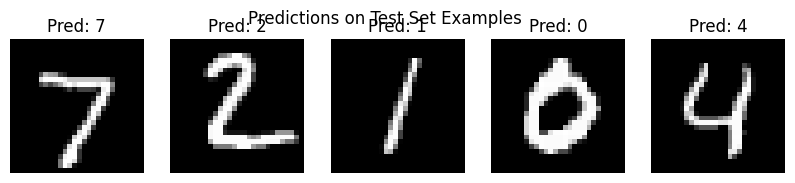

In [11]:
# Define the hinge loss function for SVM
def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_pred * y_true, min=0))

# Define the training function for each SVM classifier
def train_multi_svm(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            
            # Calculate loss for each class
            losses = []
            for i in range(outputs.size(1)):  # for each class
                y_binary = 2 * (y == i).float() - 1  # Convert labels for class i to -1 and 1
                loss = hinge_loss(outputs[:, i], y_binary)
                losses.append(loss)
                
            # Total loss is the sum of individual class losses
            total_loss = sum(losses)
            total_loss.backward()
            optimizer.step()

# Prepare the data (using train_data and test_data with labels as tensors)
X_train = torch.tensor(train_data.iloc[:, 1:].values / 255, dtype=torch.float32)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

# Create a DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model and optimizer
num_classes = 10
model = MultiClassSVM(num_classes=num_classes)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
train_multi_svm(model, train_loader, optimizer)

# Evaluate the model
X_test = torch.tensor(test_data.iloc[:, 1:].values / 255, dtype=torch.float32)
y_test = torch.tensor(test_data['label'].values, dtype=torch.long)

# Compute the predictions and choose the class with the highest score
with torch.no_grad():
    y_scores = model(X_test)
    y_pred = torch.argmax(y_scores, dim=1)

# Calculate accuracy
accuracy = (y_pred == y_test).float().mean().item()
print(f"Accuracy: {accuracy:.4f}")

# Visualize a few examples from the test set with predictions

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_data.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred[i].item()}")
    plt.axis('off')

plt.suptitle("Predictions on Test Set Examples")
plt.show()
